# 3D Vanilla Alexnet Training Script 

Here a 3D Alexnet model is implemeted using the parameters described in the original Alexnet paper. The architecture is similar to that of the 2D Alexnet, except expanded further across one dimension. The data loaded has gone through all the preprocessing steps and is ready to be fed into the CNN without any further steps.

This data has been preprocessed using the normalization range of -1100, 600.

In [1]:
import tensorflow as tf
import numpy as np
import keras
from keras.models import load_model
from tensorflow.python.keras.layers import Flatten, Conv3D, MaxPooling3D, Dropout, Input, Dense, Activation
from tensorflow.python.keras.models import Sequential, load_model
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
training_images_final = np.load("3d_training_data.npy")
training_labels = np.load("3d_training_labels.npy")
testing_images_final = np.load("3d_testing_data.npy")
testing_labels = np.load("3d_testing_labels.npy")

The callbacks are defined below.

Early stopping monitors validation loss and automatically quits the training process if the validation loss has remained constant/has increased for 5 consecutive epochs. 

Model checkpoint saves the model that performs the best on the validation dataset.

Lr_reduction reduces the learning rate by a factor of 0.1 every time the validation loss has remained constant/has increased for 2 consecutive epochs.

In [3]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
model_checkpoint = ModelCheckpoint(filepath='3d_alexnet_vanilla.h5', monitor='val_loss', save_best_only=True, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.1, min_lr=0.00001)

The model is implemented and trained below. Training logs were preserved.

In accordance with the original parameters, weight decay is implemented, the learning rate is automatically decreased in training, and a SGD optimization function with a momentum of 0.9 is used. 

In [4]:
batch_size = 128
no_epochs = 50
learning_rate = 0.01
no_classes = 2
validation_split = 0.1
verbosity = 1
X_train = training_images_final
callbacks = [early_stopping, lr_reduction]

model = Sequential()

model.add(Conv3D(filters=96, input_shape=(111, 111, 20, 3), kernel_size=(11,11,11), strides=(4,4,4), padding='valid', 
                ))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3,3,3), strides=(2,2,2), padding='same'))

model.add(Conv3D(filters=256, kernel_size=(5,5,5), strides=(1,1,1), padding='same',
                ))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3,3,3), strides=(2,2,2), padding='same'))

model.add(Conv3D(filters=384, kernel_size=(3,3,3), strides=(1,1,1), padding='same',
                ))
model.add(Activation('relu'))

model.add(Conv3D(filters=384, kernel_size=(3,3,3), strides=(1,1,1), padding='same',
                ))
model.add(Activation('relu'))

model.add(Conv3D(filters=256, kernel_size=(3,3,3), strides=(1,1,1), padding='same',
                ))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3,3,3), strides=(2,2,2), padding='same'))

model.add(Flatten())

model.add(Dense(4096, input_shape=(111*111*20*3,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(no_classes, activation='softmax', kernel_regularizer=l1(0.0005)))

model.compile(loss=keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.9), metrics=['acc'])

history = model.fit(X_train, training_labels,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split,
            callbacks = callbacks
            )


Train on 1447 samples, validate on 161 samples
Epoch 1/50
1447/1447 [==============================] - 219s 151ms/sample - loss: 0.7717 - acc: 0.5259 - val_loss: 0.7715 - val_acc: 0.5963
Epoch 2/50
1447/1447 [==============================] - 216s 149ms/sample - loss: 0.7712 - acc: 0.5314 - val_loss: 0.7709 - val_acc: 0.5776
Epoch 3/50
1447/1447 [==============================] - 217s 150ms/sample - loss: 0.7707 - acc: 0.5411 - val_loss: 0.7702 - val_acc: 0.5652
Epoch 4/50
1447/1447 [==============================] - 217s 150ms/sample - loss: 0.7700 - acc: 0.5425 - val_loss: 0.7697 - val_acc: 0.4720
Epoch 5/50
1447/1447 [==============================] - 216s 149ms/sample - loss: 0.7696 - acc: 0.5280 - val_loss: 0.7690 - val_acc: 0.4845
Epoch 6/50
1447/1447 [==============================] - 216s 149ms/sample - loss: 0.7687 - acc: 0.5321 - val_loss: 0.7684 - val_acc: 0.4969
Epoch 7/50
1447/1447 [==============================] - 216s 149ms/sample - loss: 0.7679 - acc: 0.5439 - val_loss

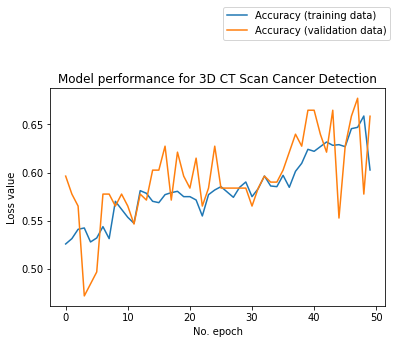

In [5]:
plt.plot(history.history['acc'], label='Accuracy (training data)')
plt.plot(history.history['val_acc'], label='Accuracy (validation data)')
plt.title('Model performance for 3D CT Scan Cancer Detection')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="lower left", bbox_to_anchor=(0.5,1.2))
plt.show()

The model has now been trained. It is then tested on unseen data in order to obtain the final testing accuracy.

In [6]:
test_results = model.evaluate(testing_images_final, testing_labels, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

403/403 [==============================] - 3s 7ms/sample - loss: 0.7115 - acc: 0.6154
Test results - Loss: 0.711491217536311 - Accuracy: 61.538463830947876%


Finally, further performance metrics are evaluated using the functions below. These metrics are:

Sensitivity: The ability of the model to classify a nodule as malignant when it is actually malignant (TP / (TP+FN))

Specificity: The ability of the model to classify a nodule as benign when it is actually benign (TN/ (TN+FP))

Precision: The accuracy of the model with regards to identifying malignant cases (i.e., how many of the predicted malignant nodules are actually malignant?) 
(TP / (TP+FP))

In [8]:
# parameters:
# arg1: labels: a list of one-hot encoded binary vectors corresponding to the actual labels of the testing data
# arg2: positive: True for positive labels (i.e. malignant), False for negative labels (i.e. benign)

# returns: 
# the number of malignant or benign cases in a one-hot encoded testing labels array

def get_true_labels(labels,positive=True):
    count = 0
    if positive == True:
        for x in labels:
            if x[1] == 1:
                count += 1
    else:
        for x in labels:
            if x[1] == 0:
                count += 1
    return count

# parameters:
# arg1: actual_labels: a list of one-hot encoded binary vectors corresponding to the actual labels of the testing data
# arg2: predicted_labels: a list of integers corresponding to the predictions of the model on the testing data (0=benign, 1=cancer)

# returns: 
# the sensitivity of the model, defined as (TP / (TP+FN))

def get_sensitivity(actual_labels, predicted_labels):
    total_positives = get_true_labels(actual_labels)
    true_positives = 0
    for i in range(len(predicted_labels)):
        if list(actual_labels[i]) == [0,1] and predicted_labels[i] == 1:
            true_positives += 1
    return true_positives/total_positives

# parameters:
# arg1: actual_labels: a list of one-hot encoded binary vectors corresponding to the actual labels of the testing data
# arg2: predicted_labels: a list of integers corresponding to the predictions of the model on the testing data (0=benign, 1=cancer)

# returns: 
# the specificity of the model, defined as (TN/ (TN+FP))

def get_specificity(actual_labels, predicted_labels):
    total_negatives = get_true_labels(actual_labels, False)
    true_negatives = 0
    for i in range(len(predicted_labels)):
        if list(actual_labels[i]) == [1,0] and predicted_labels[i] == 0:
            true_negatives += 1
    return true_negatives/total_negatives

# parameters:
# arg1: actual_labels: a list of one-hot encoded binary vectors corresponding to the actual labels of the testing data
# arg2: predicted_labels: a list of integers corresponding to the predictions of the model on the testing data (0=benign, 1=cancer)

# returns: 
# the precision of the model, defined as (TP / (TP+FP))

def get_precision(actual_labels, predicted_labels):
    true_positives = 0
    false_positives = 0
    for i in range(len(predicted_labels)):
        if list(actual_labels[i]) == [0,1] and predicted_labels[i] == 1:
            true_positives += 1
        if list(actual_labels[i]) == [1,0] and predicted_labels[i] == 1:
            false_positives += 1
    return true_positives/(true_positives+false_positives)

The list of model predictions is obtained and, along with the actual labels, is used to derive the performance metrics of the model.

In [9]:
predicted_labels = model.predict_classes(testing_images_final)

In [10]:
sensitivity = get_sensitivity(testing_labels, predicted_labels)
specificity = get_specificity(testing_labels, predicted_labels)
precision = get_precision(testing_labels, predicted_labels)
print(sensitivity, specificity, precision)

0.350253807106599 0.8689320388349514 0.71875


Finally, the performance metrics are saved.

In [11]:
f= open("3d_AlexNet_Results_Vanilla.txt","w+")
f.write("3D AlexNet Performance Metrics\n")
f.write("Loss: {0}\n".format(test_results[0]))
f.write("Accuracy: {0}\n".format(test_results[1]*100))
f.write("Sensitivity: {0}\n".format(sensitivity))
f.write("Specificity: {0}\n".format(specificity))
f.write("Precision: {0}\n".format(precision))
f.close()

In [ ]:
model.save("3d_alexnet_vanilla.h5")